In [13]:
"""
Created on Thu Nov 15 16:58:45 2018

@author: maltegueth
"""

# First thing to do is to load libraries necessary for data processing
import mne

from mne.preprocessing import ICA
from mne.preprocessing import create_ecg_epochs, corrmap

import os
import glob

import numpy as np
import pylab as pl

# I do the first few pre-processing steps for gradient artifacts in matlab
# You can find the script here:
# https://github.com/MalteGueth/EEG_fMRI_tmaze/tree/master/adaptive_gradient_correction

# So start by importing the already converted raw data (from .mff to .fif)

os.chdir('/Volumes/INTENSO/EEG_fMRI_tmaze/') # Set the working directory
file = './pilot01_mr_corrected_jn-raw.fif' # Pick the file
raw = mne.io.read_raw_fif(file, preload=True) # Create a raw object to work on and load it into memory

Opening raw data file /Volumes/INTENSO/EEG_fMRI_tmaze/pilot01_mr_corrected_jn-raw.fif...
Isotrak not found
    Range : 0 ... 1036983 =      0.000 ...  1036.983 secs
Ready.
Reading 0 ... 1036983  =      0.000 ...  1036.983 secs...


In [3]:
# The channel types, positions and other aspects are a little off 
# or impractical as they are here, so I build a new info file with a digital montage
# Note that electrode E257 has no position, because it is the online reference (Cz equivalent)

montage = mne.channels.read_montage(kind='GSN-HydroCel-257') # The digital montage file
s_freq = 1000 # The sampling rate in Hz
labels = raw.info['ch_names'] # The channel names
ch_types = list(['eeg']*257) # The first 257 channels are of type 'eeg'
ch_types.append('ecg') # add an ECG channel
ch_types.append('stim') # and the last channel is a combined (compared to the original mff format) 
                        # event trigger channel
info = mne.create_info(labels, s_freq, ch_types, montage) # Bring it all together in an info file format
info['description'] = 'Combined EEG-fMRI T-maze task, pilot subject 01 gradient corrected' # Add a little note 
                                                                                        # for the set
info['buffer_size_sec']=1 # ... minor bug, needs fixing
raw.info = info # Replace the existing info file with the custom one

The following EEG sensors did not have a position specified in the selected montage: ['E257']. Their position has been left untouched.


<ipython-input-3-f325da742216>:12: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['E257']. Their position has been left untouched.
  info = mne.create_info(labels, s_freq, ch_types, montage) # Bring it all together in an info file format


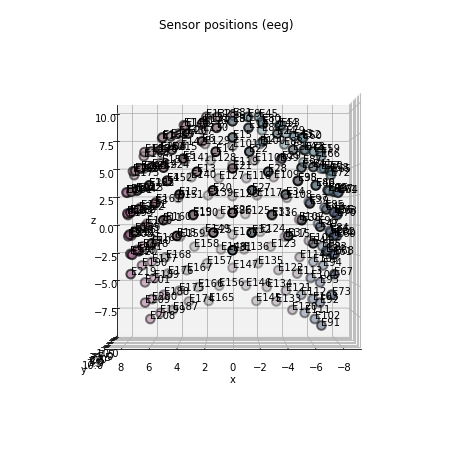

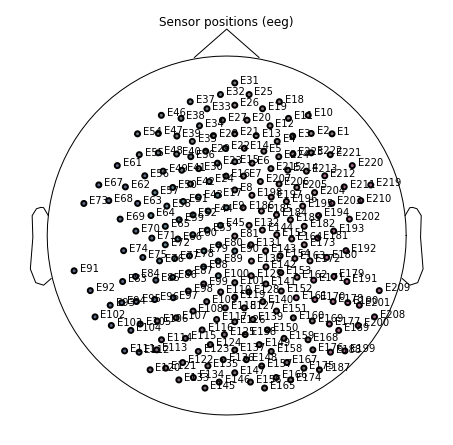

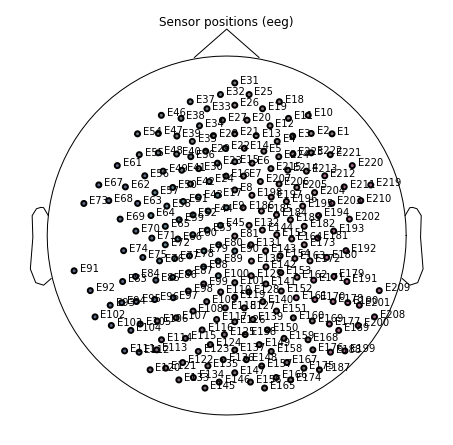

In [4]:
# A lot of the channels in the net are positioned on the cheek and the jaw,
# so they are rather emg or in some cases eog channels
# That's why I'm just using a slection of EEG channels

idx = list(np.arange(0,81))+list(np.arange(82,215))+list(np.arange(218,224)) # Get numeric indices
names = [raw.ch_names[i] for i in idx] # Get the names (i.e., 'E128')

# Plot the montage with all channel names and positions that are included
# as EEG channels...
# ... as a 3D model

raw.copy().pick_channels(names).plot_sensors(kind='3d',
                                             ch_groups='position',
                                             show_names=True)
# ... as 2D topomap

raw.copy().pick_channels(names).plot_sensors(kind='topomap',
                                             ch_groups='position',
                                             show_names=True)

# It's slightly shifted in the head surface
# I haven't fixed that issue yet

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz
Filter length of 16384 samples (16.384 sec) selected
Number of ECG events detected : 951 (average pulse 55 / min.)
951 matching events found
No baseline correction applied
Not setting metadata
Loading data for 951 events and 1001 original time points ...
0 bad epochs dropped


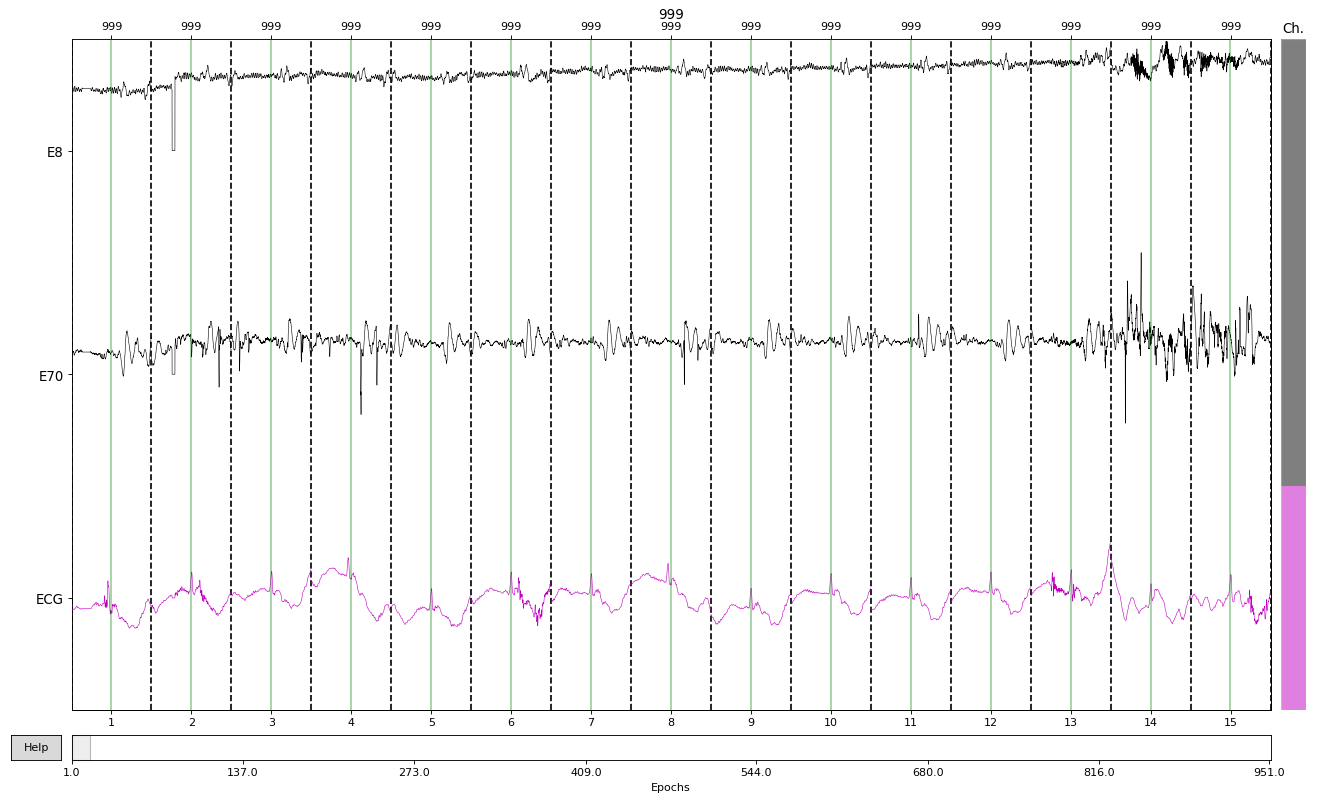

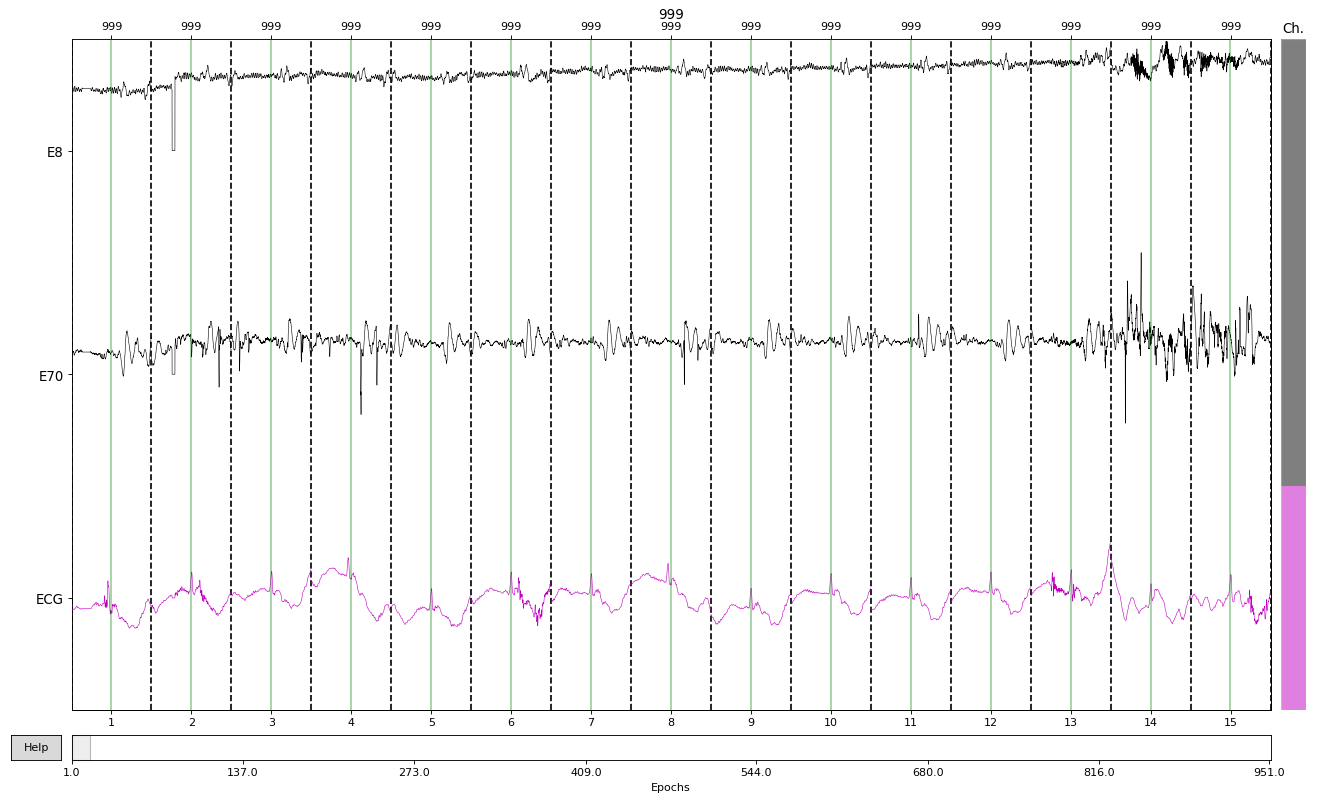

In [4]:
# Now plot 10 seconds of the raw data during the first block for all EEG channels

raw.plot(duration=10, start=100, scalings=dict(eeg=100e-6), n_channels=256)

# Add a new plot just for the ECG with some ECG channel, in order to highligh
# ballistocardiac artifacts
# Note that E8 is a frontocentral position and E70 is right above the ear
# and ballistocardiac artifacts tend to be stronger on temporal positions

ecg_epochs = create_ecg_epochs(raw, reject=None) # Perform a quick segmentation around heart beat events ECG
ecg_epochs.copy().pick_channels(['E8','E70','ECG']).plot(n_epochs=15,scalings=dict(eeg=200e-6,ecg=2000e-6),
                                                                n_channels=6)

# An automatic peak detection is run to time-lock (-0.5 and 0.5 around the peak) epochs
# Artifacts have their onset right after the R-peak (green line) of the QRS complex during 
# the ejection phase of the ECG (roughly the interval between the S and T component, 
# larger deflection in the ECG after the time-locked peak)

Opening raw data file /Volumes/INTENSO/EEG_fMRI_tmaze/pilot_uncorrected-raw.fif...
    Range : 0 ... 1036805 =      0.000 ...  1036.805 secs
Ready.
Reading 0 ... 1036805  =      0.000 ...  1036.805 secs...


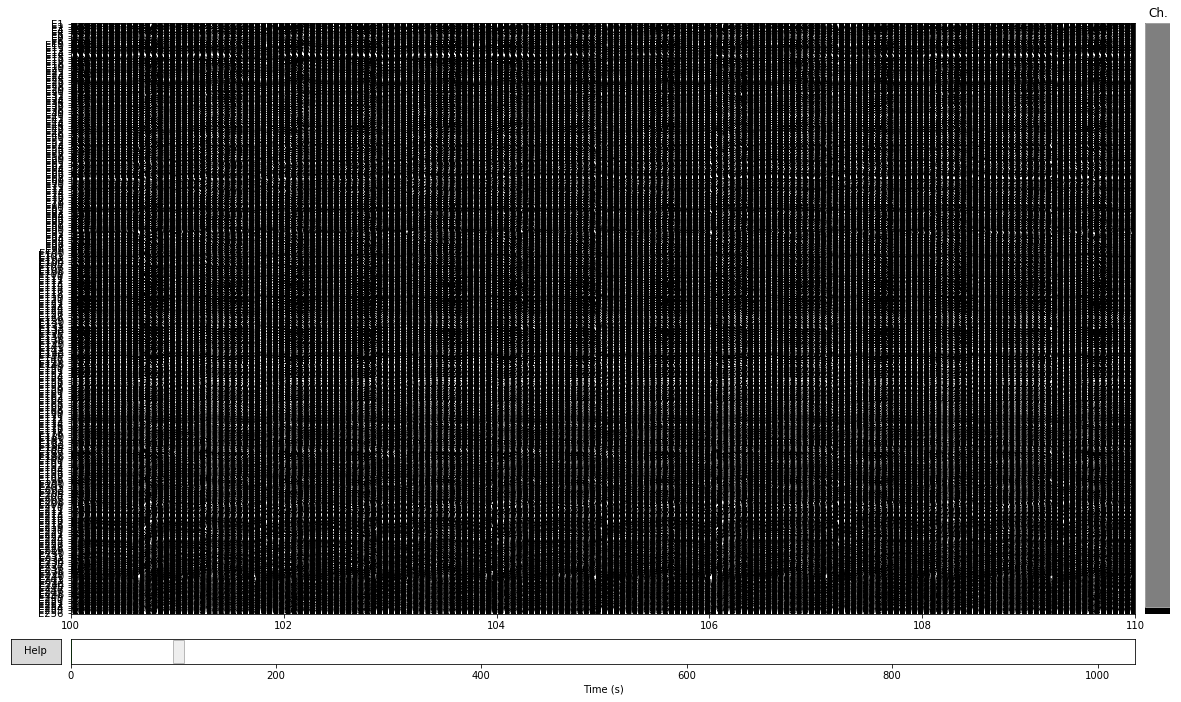

In [6]:
# Looking alright
# Compare that to the uncorrected data with all the gradient artifacts

uncorrected ='./pilot_uncorrected-raw.fif'
uncorrected = mne.io.read_raw_fif(uncorrected, preload=True)
uncorrected.plot(duration=10, start=100, scalings=dict(eeg=100e-6), n_channels=256)

Effective window size : 2.048 (s)


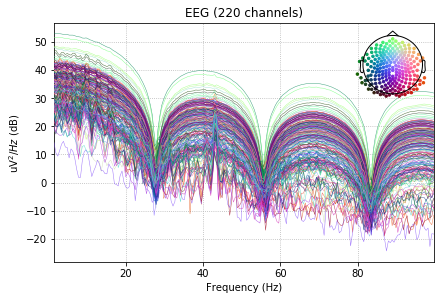

Setting up band-pass filter from 0.1 - 50 Hz
l_trans_bandwidth chosen to be 0.1 Hz
h_trans_bandwidth chosen to be 12.5 Hz
Filter length of 33001 samples (33.001 sec) selected
Effective window size : 2.048 (s)


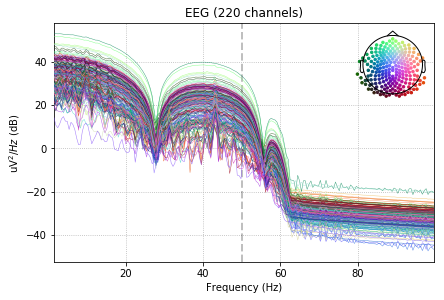

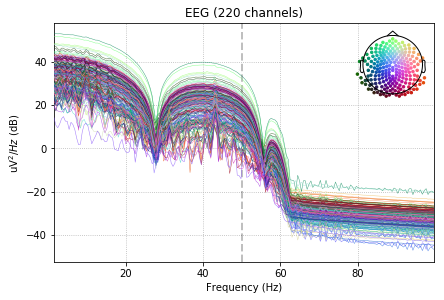

In [16]:
# Yikes, so that seems to have worked out ok. Next step is filtering
# and re-referencing to an average reference (mean of all eeg channels)

# First check the power spectrum density to get a feel for
# artifact frequencies
raw.plot_psd(area_mode='range', tmax=10.0, 
             picks=idx, average=False,
             fmin=1, fmax=100)

# ... and one more time after band-pass filtering between 0.1 and 50 Hz
raw.filter(0.1,50,fir_design='firwin')
raw.plot_psd(area_mode='range', tmax=10.0, 
             picks=idx, average=False,
             fmin=1, fmax=100)

In [17]:
# That's better, so now moving on to our new reference
raw.set_eeg_reference(ref_channels=names)

# Next, collect all the parameters necessary to run an ICA
# For demonstrational purposes decrease the sample points,
# set the number of components to 40 and pick a faster algorithm
# as method argument
n_components = 60  
method = 'fastica'
decim = 3
reject = None

ica = ICA(n_components=n_components, method=method) 

# Also, to prevent slow drifts from biasing the ICA, filter a copy
# of the signal with another band-pass and use the back-projection
# later on the original signal
ica.fit(raw.copy().filter(1,50), picks=None, decim=decim, reject=reject)

# Plot the extracted signal components
#ica = mne.preprocessing.read_ica('/Volumes/INTENSO/EEG_fMRI_tmaze/pilot_fix_60comp-ica.fif')
ica.plot_components(outlines='skirt')

Applying a custom EEG reference.
Setting up band-pass filter from 1 - 50 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 12.5 Hz
Filter length of 3301 samples (3.301 sec) selected
Fitting ICA to data using 257 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 60 components
Fitting ICA took 16.1s.


[<Figure size 540x504 with 20 Axes>,
 <Figure size 540x504 with 20 Axes>,
 <Figure size 540x504 with 20 Axes>]

    using multitaper spectrum estimation with 7 DPSS windows


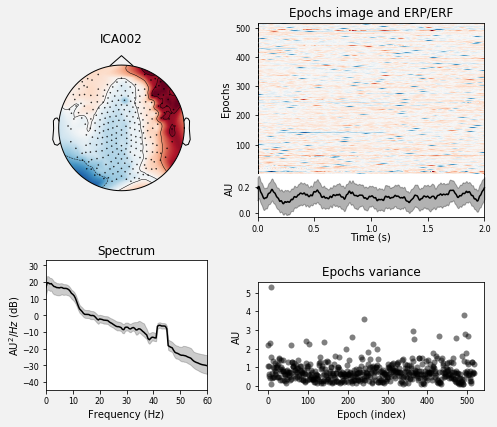

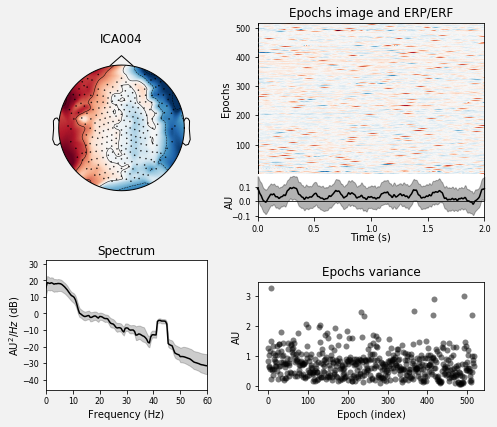

[<Figure size 504x432 with 5 Axes>, <Figure size 504x432 with 5 Axes>]

In [4]:
# Let's look at some typical ballistocardiac artifacts and a likely signal
# component (topography, frequency spectrum, variance, etc) along with their
# source signals and the ECG channel

# See anything that might look like heart beats in the first 20 components?
ica.plot_sources(raw, picks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

# We can have a closer look at their properties
ica.plot_properties(raw, picks=[2,4], psd_args={'fmax': 60.})

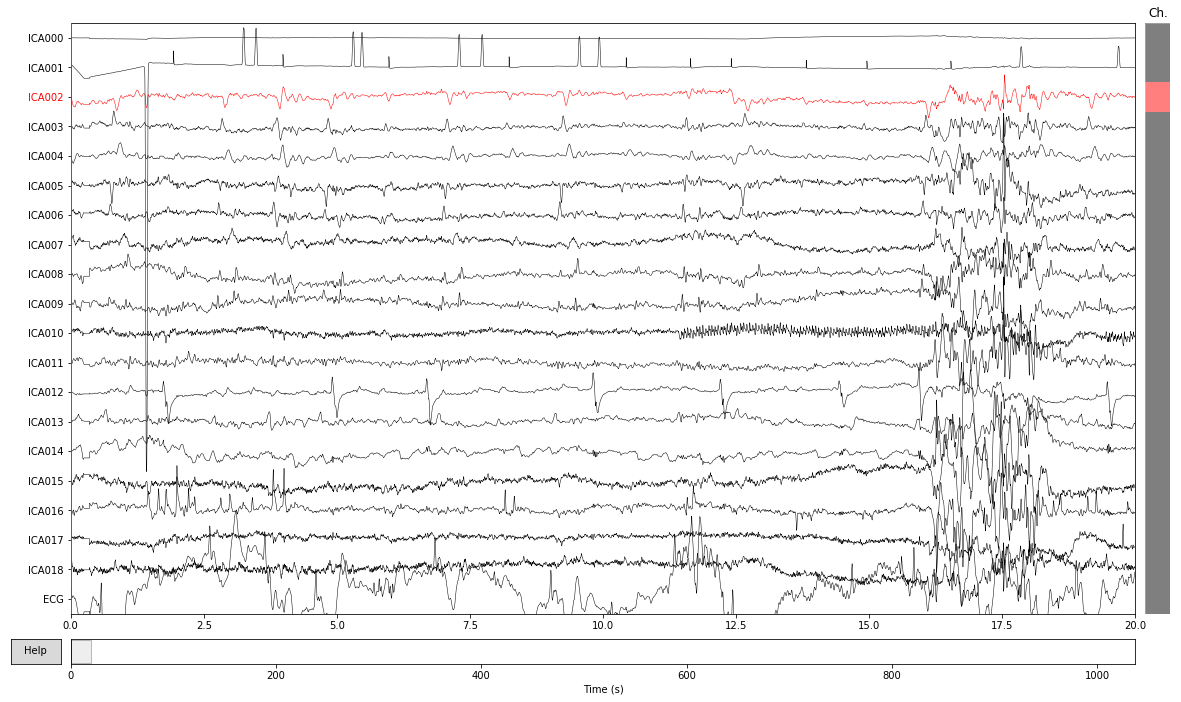

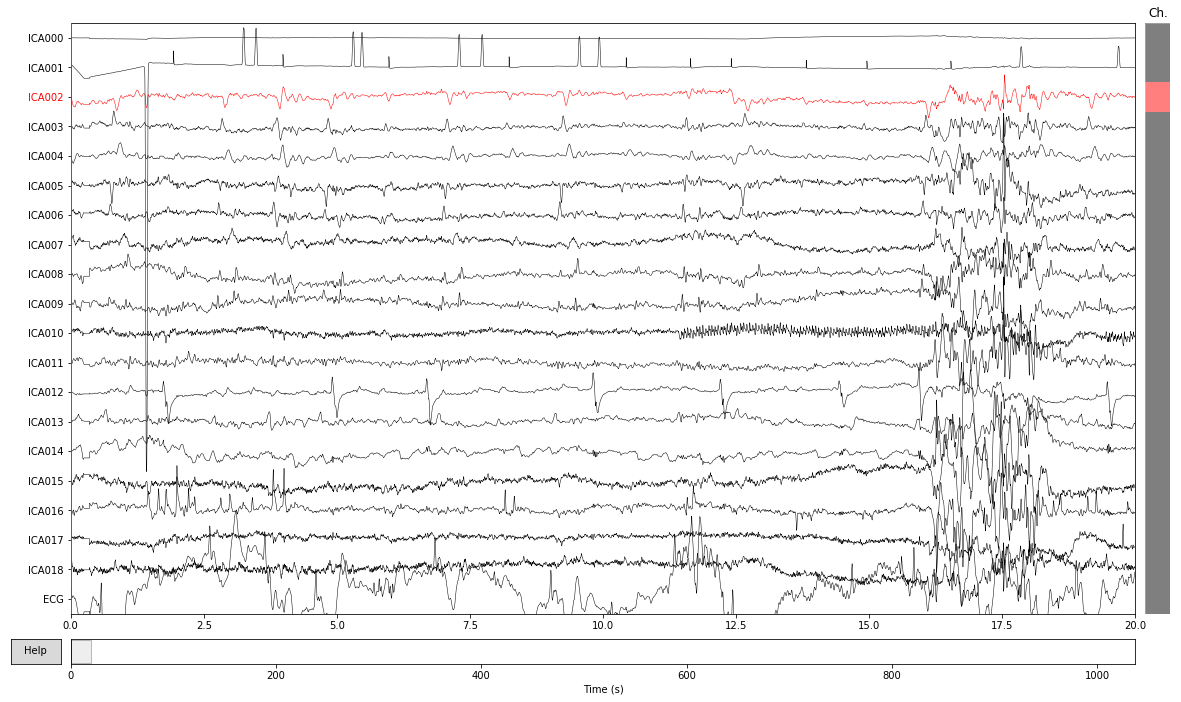

In [3]:
# To find components reflecting ballistocardiac artifacts, correlate
# the ECG signal with the continuous contribution of single ICA 
# components

from scipy.stats import pearsonr

corr = lambda x, y: np.array([pearsonr(a, y.ravel()) for a in x])[:, 0]

# The find_sources method returns and array of correlation
# scores for each ICA source.
ecg_scores = ica.score_sources(raw, target='ECG', score_func=corr)

# Get the component index of the maximum correlation with the ECG
ecg_source_idx = np.abs(ecg_scores).argmax()

# Mark the source with the maximum correlation
ica.plot_sources(raw, exclude=[ecg_source_idx], picks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])

In [6]:
# Alternatively, we can threshold and plot the component
# scores for every ICA component based on cross-trial phase statistics

# Create ECG epochs around likely artifact events and average them 
ecg_average = create_ecg_epochs(raw, reject=None).average()

# Create ECG epochs around likely artifact events and correlate them
# to all ICA component source signal time course
# Build artifact scores via the correlation anaylsis
ecg_epochs = create_ecg_epochs(raw, reject=None)
ecg_inds, scores = ica.find_bads_ecg(ecg_epochs, threshold=0.2, method='ctps')

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz
Filter length of 16384 samples (16.384 sec) selected
Number of ECG events detected : 833 (average pulse 48 / min.)
833 matching events found
No baseline correction applied
Not setting metadata
Loading data for 833 events and 1001 original time points ...
0 bad epochs dropped
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz
Filter length of 16384 samples (16.384 sec) selected
Number of ECG events detected : 833 (average pulse 48 / min.)
833 matching events found
No baseline correction applied
Not setting metadata
Loading data for 833 events and 1001 original time points ...
0 bad epochs dropped


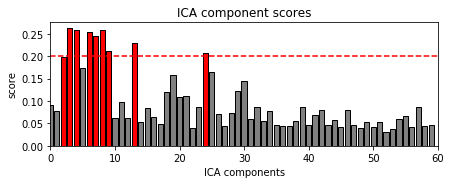

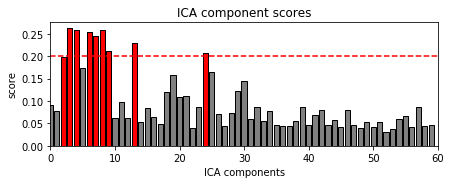

In [11]:
# Plot the artifact scores / correlations across ICA components
# and retrieve component numbers of sources likely representing
# caridoballistic artifacts
ica.plot_scores(scores, title='ICA component scores',
                exclude=ecg_inds, # Mark the identified cardiac artifact components red
                show=True, 
                axhline=0.2) # Plot a horizontal line to mark the score threshold

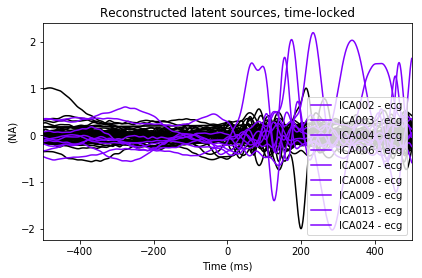

Transforming to ICA space (60 components)
Zeroing out 9 ICA components


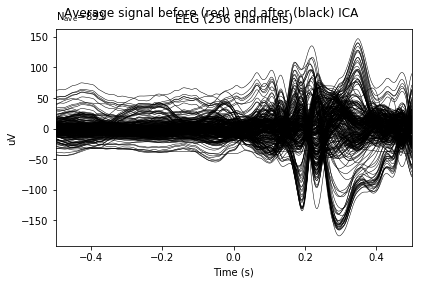

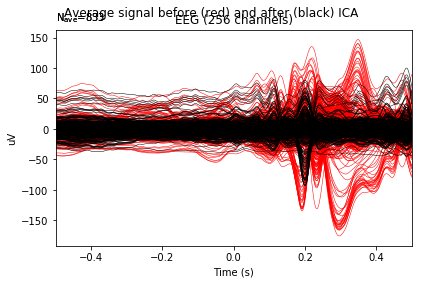

In [12]:
# To improve your selection, inspect the ica components' 
# source signal time course and compare it to the average ecg artifact 
ica.plot_sources(ecg_average, exclude=ecg_inds)

# Also, overlay the raw data with the cleaned signal (given the artifact indices)
ica.plot_overlay(ecg_average, exclude=ecg_inds)

In [39]:
# There is one more way how you can improve your ICA-based correction,
# which is by validating single subject ICA decompositions with a 
# shared reference ICA

# Loop through all the subjects (right now, only two...) to load 
# them in and append in a list
icas_subjects = list()

# The same pre-processing pipeline was run on our second subject
# whose ICA decomposition is now loaded into memory

path_ica = './ICA/'
for file in glob.glob(os.path.join(path_ica, '*-ica.fif')):
  
    current_ica = mne.preprocessing.read_ica(file)
    icas_subjects.append(current_ica)

reference_ica = icas_subjects[0] # Pick the first subject as a reference ICA
                                 # The reference should usually be one with particulalry well
                                 # identified components
all_icas = [reference_ica] + icas_subjects

# Build a tuple with the reference ica and the index of the representative
# component that is to form the template
cardio_template = (0, ecg_inds[0])
    
# Run the corrmap algorithm to compare the artifact template to all other 
# components from the remaining subjects
# Find all components that correlate to the template
fig_template, fig_detected = corrmap(all_icas, template=cardio_template, 
                                     label="ballistocardiac", show=True)

Reading ./ICA/pilot_fix_60comp-ica.fif ...
Now restoring ICA solution ...
Ready.


Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


Transforming to ICA space (60 components)
Zeroing out 13 ICA components


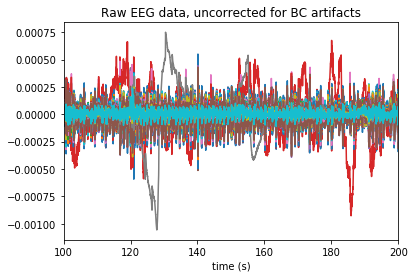

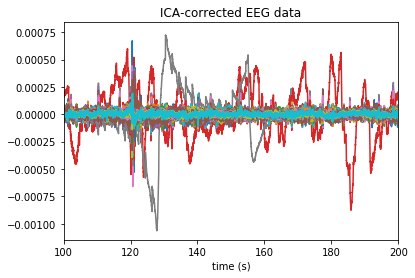

In [7]:
# Depending on the template results, adjust the indices collected from
# the ECG analysis (i.e., correct only intersection between the two)

# If no fruther refinement of the artifact selection is required, add
# components reflecting different kind of artifacts (blinks, saccades),
# back-project the non-artifact components to the mixed, continuous signal
# Enter an array of bad indices to zero out components
# start and end arguments can mark the first and last sample of the set to be
# affected by the back-projection

raw_ica = ica.apply(raw.copy(), exclude=ecg_inds)

# Compare the ICA pre-processed version with the previous pre-processing stage
start, stop = raw.time_as_index([100, 200])
data, times = raw[idx, start:stop]
data_clean, _ = raw_ica[idx, start:stop]

# Raw data without ICA correction
pl.figure()
pl.plot(times, data.T)
pl.xlabel('time (s)')
pl.xlim(100, 200)
pl.title('Raw EEG data, uncorrected for BC artifacts')
y0, y1 = pl.ylim()

# ICA-corrected data
pl.figure()
pl.plot(times, data_clean.T)
pl.xlabel('time (s)')
pl.xlim(100, 200)
pl.title('ICA-corrected EEG data')
pl.ylim(y0, y1)
pl.show()

# Perform another quick segmentation around heart beat events ECG after the ICA correction
#ecg_epochs = create_ecg_epochs(raw, reject=None)
#ecg_epochs.copy().pick_channels(['E8','E70','ECG']).plot(n_epochs=15,scalings=dict(eeg=100e-6,ecg=2000e-6),
#                                                         n_channels=6)